Посмотрим на все файлы, которые были предоставлены

In [59]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path


def parse_dates(fires, temperature, supplies, weather):
    fires["fire_start"] = pd.to_datetime(fires["fire_start"], errors="coerce")
    fires["fire_end"] = pd.to_datetime(fires["fire_end"], errors="coerce")
    fires["pile_start"] = pd.to_datetime(fires["pile_start"], errors="coerce")

    temperature["act_date"] = pd.to_datetime(temperature["act_date"], errors="coerce")
    temperature["date"] = temperature["act_date"].dt.date
    temperature["date"] = pd.to_datetime(temperature["date"])

    supplies["unload_time"] = pd.to_datetime(supplies["unload_time"], errors="coerce")
    supplies["load_time"] = pd.to_datetime(supplies["load_time"], errors="coerce")

    supplies["unload_date"] = pd.to_datetime(supplies["unload_time"].dt.date)
    supplies["load_date"] = pd.to_datetime(supplies["load_time"].dt.date)

    date_col = None
    for cand in ["dt", "date", "datetime", "time"]:
        if cand in weather.columns:
            date_col = cand
            break

    weather[date_col] = pd.to_datetime(weather[date_col], errors="coerce")
    weather["date"] = pd.to_datetime(weather[date_col].dt.date)

    return fires, temperature, supplies, weather


def build_temperature_daily(temperature: pd.DataFrame) -> pd.DataFrame:
    agg = (
        temperature
        .sort_values(["pile_id", "date"])
        .groupby(["pile_id", "date"])
        .agg(
            temp_max_mean=("temp_max", "mean"),
            temp_max_min=("temp_max", "min"),
            temp_max_max=("temp_max", "max"),
            temp_max_std=("temp_max", "std"),
            n_measurements=("temp_max", "count"),
            coal_grade=("coal_grade", "first")  # тянем категорию
        )
        .reset_index()
    )

    return agg


def build_supplies_daily(supplies: pd.DataFrame) -> pd.DataFrame:
    # приход на склад
    incoming = (
        supplies
        .dropna(subset=["unload_date"])
        .groupby(["pile_id", "unload_date"])
        .agg(
            to_stock_tons_daily=("to_stock_tons", "sum")
        )
        .reset_index()
        .rename(columns={"unload_date": "date"})
    )

    # расход со склада
    outgoing = (
        supplies
        .dropna(subset=["load_date"])
        .groupby(["pile_id", "load_date"])
        .agg(
            from_stock_tons_daily=("from_stock_tons", "sum")
        )
        .reset_index()
        .rename(columns={"load_date": "date"})
    )

    daily = pd.merge(
        incoming,
        outgoing,
        on=["pile_id", "date"],
        how="outer"
    )

    daily["to_stock_tons_daily"] = daily["to_stock_tons_daily"].fillna(0.0)
    daily["from_stock_tons_daily"] = daily["from_stock_tons_daily"].fillna(0.0)

    daily = daily.sort_values(["pile_id", "date"])
    daily["net_flow"] = daily["to_stock_tons_daily"] - daily["from_stock_tons_daily"]

    daily["stock_tons"] = (
        daily
        .groupby("pile_id")["net_flow"]
        .cumsum()
    )

    return daily


def build_weather_daily(weather: pd.DataFrame) -> pd.DataFrame:
    agg = (
        weather
        .groupby("date")
        .agg(
            temp_air_mean=("temp_air", "mean"),
            temp_air_min=("temp_air", "min"),
            temp_air_max=("temp_air", "max"),
            humidity_mean=("humidity", "mean"),
            precip_sum=("precip", "sum"),
            wind_avg_mean=("wind_avg", "mean"),
            wind_max_max=("wind_max", "max"),
            cloudcover_mean=("cloudcover", "mean")
        )
        .reset_index()
    )
    return agg


def add_fire_labels(base_df: pd.DataFrame, fires: pd.DataFrame,
                    horizon_days: int = 3) -> pd.DataFrame:
    fire_first = (
        fires
        .dropna(subset=["fire_start"])
        .sort_values("fire_start")
        .groupby("pile_id")
        .first()
        .reset_index()[["pile_id", "fire_start", "coal_grade", "stockyard"]]
    )

    df = base_df.merge(fire_first, on="pile_id", how="left", suffixes=("", "_fire"))

    df["days_to_fire"] = (df["fire_start"] - df["date"]).dt.days
    df["days_to_fire"] = df["days_to_fire"].astype("float")

    df["fire_in_horizon"] = np.where(
        (df["days_to_fire"] >= 0) & (df["days_to_fire"] <= horizon_days),
        1, 0
    )

    df["ever_fire"] = np.where(df["fire_start"].notna(), 1, 0)

    return df

def add_stockyard_from_supplies(full_df: pd.DataFrame, supplies: pd.DataFrame) -> pd.DataFrame:
    supplies_meta = (
        supplies[["pile_id", "stockyard"]]
        .dropna(subset=["stockyard"])
        .sort_values(["pile_id"])      # нужно ли?
        .groupby("pile_id", as_index=False)
        .first()
    )

    df = full_df.merge(
        supplies_meta,
        on="pile_id",
        how="left",
        suffixes=("", "_sup")
    )

    df["stockyard"] = df["stockyard"].fillna(df["stockyard_sup"])

    df = df.drop(columns=["stockyard_sup"])

    if df["stockyard"].isna().any():
        mode_val = df["stockyard"].mode()
        if len(mode_val) > 0:
            df["stockyard"] = df["stockyard"].fillna(mode_val[0])

    return df

def build_full_dataset(data_dir: str,
                       horizon_days: int = 3) -> pd.DataFrame:
    fires, temperature, supplies, weather = load_raw_data(data_dir)
    fires, temperature, supplies, weather = rename_columns(
        fires, temperature, supplies, weather
    )
    fires, temperature, supplies, weather = parse_dates(
        fires, temperature, supplies, weather
    )

    temp_daily = build_temperature_daily(temperature)
    supplies_daily = build_supplies_daily(supplies)
    weather_daily = build_weather_daily(weather)

    base = temp_daily.merge(
        supplies_daily,
        on=["pile_id", "date"],
        how="left"
    )

    base = base.merge(
        weather_daily,
        on="date",
        how="left"
    )

    full_df = add_fire_labels(base, fires, horizon_days=horizon_days)
    full_df = add_stockyard_from_supplies(full_df, supplies)

    full_df["temp_max_std"] = full_df["temp_max_std"].fillna(0.0)

    for col in ["to_stock_tons_daily", "from_stock_tons_daily", "net_flow", "stock_tons"]:
        if col in full_df.columns:
            full_df[col] = full_df[col].fillna(0.0)


    full_df = (
        full_df
        .sort_values(["pile_id", "date"])
        .drop_duplicates(subset=["pile_id", "date"], keep="first")
        .reset_index(drop=True)
    )

    return full_df

In [60]:
import numpy as np

In [61]:
import pandas as pd

fires = pd.read_csv("data/fires.csv")
fires.head()


,Дата составления,Груз,"Вес по акту, тн",Склад,Дата начала,Дата оконч.,Нач.форм.штабеля,Штабель
0,2019-03-19,A1,255.00,4,2019-03-19 09:00:00,2019-03-19 21:00:00,2018-11-23 00:00:00,6
1,2019-03-24,B2,42.50,3,2019-03-24 09:00:00,2019-03-24 21:00:00,2019-01-03 00:00:00,21
2,2019-03-25,B2,72.25,3,2018-03-24 21:00:00,2019-03-25 09:00:00,2019-01-03 00:00:00,21
3,2019-06-11,A1,127.50,4,2019-06-11 09:00:00,2019-06-11 21:00:00,2019-04-28 23:55:00,15
4,2019-07-07,A1,127.50,4,2019-07-06 21:00:00,2019-07-07 09:00:00,2019-05-19 00:00:00,22


Всего видов угля:

In [62]:
fires[["Склад", "Груз"]].groupby("Склад")["Груз"].unique()

,Груз
Склад,
3,"[B2, A1]"
4,"[A1, E5]"
6,[A1]


In [63]:
supp = pd.read_csv("data/supplies.csv")
supp.head()

,ВыгрузкаНаСклад,Наим. ЕТСНГ,Штабель,ПогрузкаНаСудно,"На склад, тн","На судно, тн",Склад
0,2019-01-02,E5,1,2019-02-08,11984.1925,11984.1925,3
1,2019-01-02,A1,34,2019-02-12,3913.8250,3913.8250,3
2,2019-01-02,A1,37,2019-02-23,11626.9120,11626.9120,3
3,2019-01-02,A1,44,2019-01-04,184.7815,184.7815,4
4,2019-01-02,C3,22,2019-02-07,9520.3315,9520.3315,3


In [64]:
x = np.min(supp["ВыгрузкаНаСклад"])
y = np.max(supp["ВыгрузкаНаСклад"])
print(f'Данные о поставках с: {x} до: {y}')

Данные о поставках с: 2019-01-02 до: 2020-09-30


In [65]:
temp = pd.read_csv("data/temperature.csv")
temp.head()

,Склад,Штабель,Марка,Максимальная температура,Пикет,Дата акта,Смена
0,3,43,A1,36.2,3045-3075,2020-08-05,219.0
1,4,39,A1,109.4,4025-4047,2020-08-05,219.0
2,4,23,A1,38.6,4048-4052,2020-08-05,219.0
3,4,46,A1,37.3,4057-4077,2020-08-05,219.0
4,4,12,A1,36.4,4091-4112,2020-08-05,219.0


In [81]:
import numpy as np
weather = pd.read_csv("data/weather_data_2015.csv")
weather.head()

,date,t,p,humidity,precipitation,wind_dir,v_avg,v_max,cloudcover,visibility,weather_code
0,2015-01-01 00:00:00,-2.1,1026.6,75,0.0,41,34.2,54.0,98,NaN,3
1,2015-01-01 01:00:00,-2.1,1025.9,73,0.0,40,32.2,52.2,99,NaN,3
2,2015-01-01 02:00:00,-2.2,1026.1,75,0.0,36,32.2,50.4,99,NaN,3
3,2015-01-01 03:00:00,-2.2,1025.8,75,0.0,34,33.2,51.5,97,NaN,3
4,2015-01-01 04:00:00,-2.3,1025.9,76,0.0,33,33.5,52.6,100,NaN,3


Получается, что у нас период: 2019-01-02 до: 2020-09-30

Прочитаем все файлы для дальнейшней обработки

In [82]:
def load_raw_data(data_dir: str):
    data_dir = Path(data_dir)

    fires = pd.read_csv(data_dir / "fires.csv", sep=",")
    temperature = pd.read_csv(data_dir / "temperature.csv", sep=",")
    supplies = pd.read_csv(data_dir / "supplies.csv", sep=",")

    weather_files = glob.glob(str(data_dir / "weather_data_*.csv"))
    weather_list = [pd.read_csv(f, sep=",") for f in weather_files]
    weather = pd.concat(weather_list, ignore_index=True)

    return fires, temperature, supplies, weather



def rename_columns(fires, temperature, supplies, weather):
    fires = fires.rename(columns={
        "Груз": "coal_grade",
        "Склад": "stockyard",
        "Дата начала": "fire_start",
        "Дата оконч.": "fire_end",
        "Нач.форм.штабеля": "pile_start",
        "Штабель": "pile_id"
    })

    temperature = temperature.rename(columns={
        "Штабель": "pile_id",
        "Марка": "coal_grade",
        "Максимальная температура": "temp_max",
        "Пикет": "location",
        "Дата акта": "act_date",
        "Смена": "shift"
    })

    supplies = supplies.rename(columns={
        "ВыгрузкаНаСклад": "unload_time",
        "Наим. ЕТСНГ": "coal_grade",
        "Штабель": "pile_id",
        "ПогрузкаНаСудно": "load_time",
        "На склад, тн": "to_stock_tons",
        "На судно, тн": "from_stock_tons",
        "Склад": "stockyard"
    })

    weather = weather.rename(columns={
        "t": "temp_air",
        "p": "pressure",
        "humidity": "humidity",
        "precipitation": "precip",
        "wind_dir": "wind_dir",
        "v_avg": "wind_avg",
        "v_max": "wind_max",
        "cloudcover": "cloudcover",
        "visibility": "visibility",
        "weather_code": "weather_code"
    })

    return fires, temperature, supplies, weather

начнем соединять данные в одну таблицу для дальнейшего анализа

В качестве тагрета будем использовать количество дней до пожара от текущей даты

In [97]:
def parse_dates(fires, temperature, supplies, weather):

    fires["fire_start"] = pd.to_datetime(fires["fire_start"], errors="coerce")
    fires["fire_end"] = pd.to_datetime(fires["fire_end"], errors="coerce")
    fires["pile_start"] = pd.to_datetime(fires["pile_start"], errors="coerce")

    temperature["act_date"] = pd.to_datetime(temperature["act_date"], errors="coerce")
    temperature["date"] = temperature["act_date"].dt.date
    temperature["date"] = pd.to_datetime(temperature["date"])

    supplies["unload_time"] = pd.to_datetime(supplies["unload_time"], errors="coerce")
    supplies["load_time"] = pd.to_datetime(supplies["load_time"], errors="coerce")

    supplies["unload_date"] = pd.to_datetime(supplies["unload_time"].dt.date)
    supplies["load_date"] = pd.to_datetime(supplies["load_time"].dt.date)

    date_col = None
    for cand in ["dt", "date", "datetime", "time"]:
        if cand in weather.columns:
            date_col = cand
            break

    weather[date_col] = pd.to_datetime(weather[date_col], errors="coerce")
    weather["date"] = pd.to_datetime(weather[date_col].dt.date)

    return fires, temperature, supplies, weather


def build_temperature_daily(temperature: pd.DataFrame) -> pd.DataFrame:
    agg = (
        temperature
        .sort_values(["pile_id", "date"])
        .groupby(["pile_id", "date"])
        .agg(
            temp_max_mean=("temp_max", "mean"),
            temp_max_min=("temp_max", "min"),
            temp_max_max=("temp_max", "max"),
            temp_max_std=("temp_max", "std"),
            n_measurements=("temp_max", "count"),
            coal_grade=("coal_grade", "first")  # тянем категорию
        )
        .reset_index()
    )

    return agg


def build_supplies_daily(supplies: pd.DataFrame) -> pd.DataFrame:
    # приход на склад
    incoming = (
        supplies
        .dropna(subset=["unload_date"])
        .groupby(["pile_id", "unload_date"])
        .agg(
            to_stock_tons_daily=("to_stock_tons", "sum")
        )
        .reset_index()
        .rename(columns={"unload_date": "date"})
    )

    # расход со склада
    outgoing = (
        supplies
        .dropna(subset=["load_date"])
        .groupby(["pile_id", "load_date"])
        .agg(
            from_stock_tons_daily=("from_stock_tons", "sum")
        )
        .reset_index()
        .rename(columns={"load_date": "date"})
    )

    daily = pd.merge(
        incoming,
        outgoing,
        on=["pile_id", "date"],
        how="outer"
    )

    daily["to_stock_tons_daily"] = daily["to_stock_tons_daily"].fillna(0.0)
    daily["from_stock_tons_daily"] = daily["from_stock_tons_daily"].fillna(0.0)

    daily = daily.sort_values(["pile_id", "date"])
    daily["net_flow"] = daily["to_stock_tons_daily"] - daily["from_stock_tons_daily"]

    daily["stock_tons"] = (
        daily
        .groupby("pile_id")["net_flow"]
        .cumsum()
    )

    return daily


def build_weather_daily(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Агрегируем погоду по дням.
    """
    agg = (
        weather
        .groupby("date")
        .agg(
            temp_air_mean=("temp_air", "mean"),
            temp_air_min=("temp_air", "min"),
            temp_air_max=("temp_air", "max"),
            humidity_mean=("humidity", "mean"),
            precip_sum=("precip", "sum"),
            wind_avg_mean=("wind_avg", "mean"),
            wind_max_max=("wind_max", "max"),
            cloudcover_mean=("cloudcover", "mean"),
            visibility_mean=("visibility", "mean")
        )
        .reset_index()
    )
    return agg


def add_fire_labels(base_df: pd.DataFrame, fires: pd.DataFrame,
                    horizon_days: int = 3) -> pd.DataFrame:
    fire_first = (
        fires
        .dropna(subset=["fire_start"])
        .sort_values("fire_start")
        .groupby("pile_id")
        .first()
        .reset_index()[["pile_id", "fire_start", "coal_grade", "stockyard"]]
    )

    df = base_df.merge(fire_first, on="pile_id", how="left", suffixes=("", "_fire"))

    df["days_to_fire"] = (df["fire_start"] - df["date"]).dt.days
    df["days_to_fire"] = df["days_to_fire"].astype("float")

    df["fire_in_horizon"] = np.where(
        (df["days_to_fire"] >= 0) & (df["days_to_fire"] <= horizon_days),
        1, 0
    )

    df["ever_fire"] = np.where(df["fire_start"].notna(), 1, 0)

    return df


def add_stockyard_from_supplies(full_df: pd.DataFrame, supplies: pd.DataFrame) -> pd.DataFrame:
    supplies_meta = (
        supplies[["pile_id", "stockyard"]]
        .dropna()
        .drop_duplicates()
    )

    df = full_df.merge(
        supplies_meta,
        on="pile_id",
        how="left",
        suffixes=("", "_sup")
    )

    df["stockyard"] = df["stockyard"].fillna(df["stockyard_sup"])
    df = df.drop(columns=["stockyard_sup"])

    return df


def build_full_dataset(data_dir: str,
                       horizon_days: int = 3) -> pd.DataFrame:
    fires, temperature, supplies, weather = load_raw_data(data_dir)
    fires, temperature, supplies, weather = rename_columns(
        fires, temperature, supplies, weather
    )
    fires, temperature, supplies, weather = parse_dates(
        fires, temperature, supplies, weather
    )

    temp_daily = build_temperature_daily(temperature)
    supplies_daily = build_supplies_daily(supplies)
    weather_daily = build_weather_daily(weather)

    base = temp_daily.merge(
        supplies_daily,
        on=["pile_id", "date"],
        how="left"
    )

    base = base.merge(
        weather_daily,
        on="date",
        how="left"
    )

    full_df = add_fire_labels(base, fires, horizon_days=horizon_days)
    full_df = add_stockyard_from_supplies(full_df, supplies)


    return full_df



In [98]:
full_df = build_full_dataset("./data", horizon_days=3)


In [99]:
full_df = (
        full_df
        .sort_values(["pile_id", "date"])
        .drop_duplicates(subset=["pile_id", "date"], keep="first")
        .reset_index(drop=True)
    )

Посмотрим на таблицу целиком

In [95]:
full_df

,pile_id,date,temp_max_mean,temp_max_min,temp_max_max,temp_max_std,n_measurements,coal_grade,to_stock_tons_daily,from_stock_tons_daily,...,wind_avg_mean,wind_max_max,cloudcover_mean,visibility_mean,fire_start,coal_grade_fire,stockyard,days_to_fire,fire_in_horizon,ever_fire
0,0,2020-05-29,26.3,26.3,26.3,NaN,1,A1,NaN,NaN,...,18.950000,36.4,82.083333,NaN,NaT,NaN,NaN,NaN,0,0
1,1,2020-04-27,23.2,22.7,23.7,0.707107,2,A1,0.0000,24646.0985,...,16.116667,36.0,41.375000,NaN,2019-08-04 09:00:00,A1,3.0,-267.0,0,1
2,1,2020-04-27,23.2,22.7,23.7,0.707107,2,A1,0.0000,24646.0985,...,16.116667,36.0,41.375000,NaN,2019-08-04 09:00:00,A1,3.0,-267.0,0,1
3,1,2020-04-28,24.7,21.7,27.7,4.242641,2,A1,NaN,NaN,...,19.145833,34.9,18.958333,NaN,2019-08-04 09:00:00,A1,3.0,-268.0,0,1
4,1,2020-04-28,24.7,21.7,27.7,4.242641,2,A1,NaN,NaN,...,19.145833,34.9,18.958333,NaN,2019-08-04 09:00:00,A1,3.0,-268.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,58,2020-07-24,38.4,36.9,39.9,2.121320,2,A1,23083.1950,0.0000,...,22.712500,40.3,27.125000,NaN,NaT,NaN,3.0,NaN,0,0
4638,58,2020-07-25,33.7,33.7,33.7,NaN,1,A1,NaN,NaN,...,27.783333,42.1,8.166667,NaN,NaT,NaN,3.0,NaN,0,0
4639,60,2020-07-25,36.2,36.2,36.2,NaN,1,A1,49048.0175,0.0000,...,27.783333,42.1,8.166667,NaN,NaT,NaN,4.0,NaN,0,0
4640,62,2020-07-28,36.0,34.1,37.9,2.687006,2,A1,2119.1350,0.0000,...,14.958333,33.5,61.375000,NaN,NaT,NaN,3.0,NaN,0,0


Посмотрим на пустые

In [92]:
full_df.isna().sum()

,0
pile_id,0
date,0
temp_max_mean,0
temp_max_min,0
temp_max_max,0
temp_max_std,1261
n_measurements,0
coal_grade,0
to_stock_tons_daily,2326
from_stock_tons_daily,2326


Выбросим бесполезные признаки (пустые)

In [102]:
full_df_1 = full_df.drop(columns=["visibility_mean"])

Посчитаем корреляцию признаков

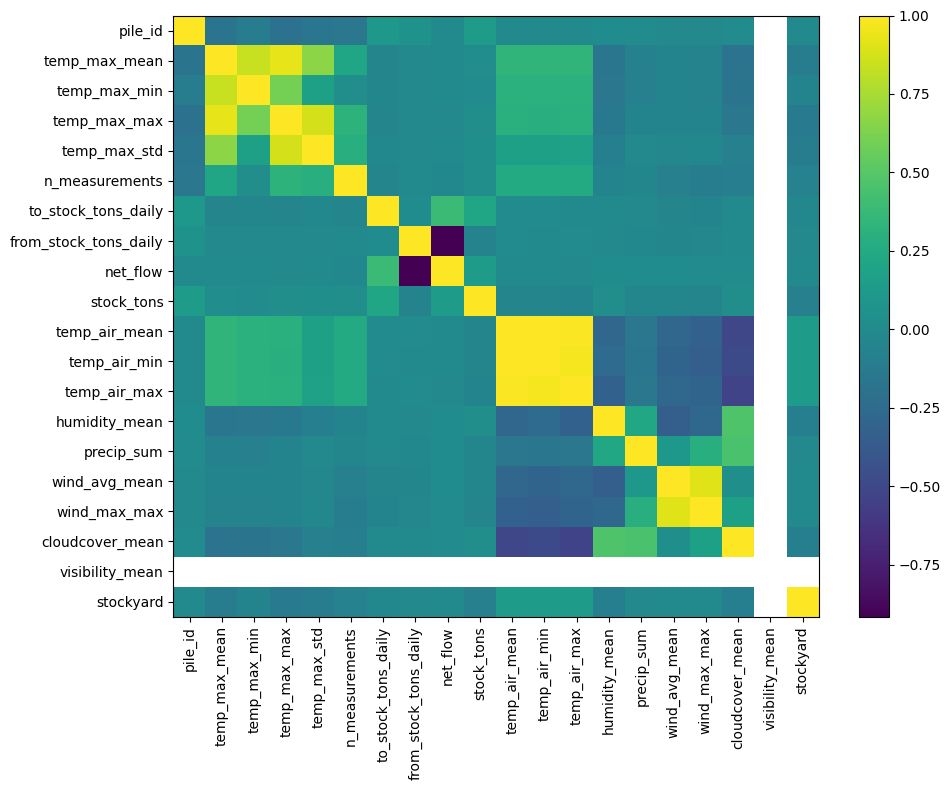

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

num_df = full_df.select_dtypes(include=[np.number]).copy()

leak_cols = ["days_to_fire", "fire_in_horizon", "ever_fire"]
num_df = num_df.drop(columns=[c for c in leak_cols if c in num_df.columns])

num_df = num_df.fillna(num_df.median(numeric_only=True))

corr = num_df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

Воспользуемся методом главых компонент для анализа данных о возгораниях

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
full_df_1 = full_df.drop(columns=["stockyard", "visibility_mean", "temp_max_std", "to_stock_tons_daily", "from_stock_tons_daily", "net_flow", "stock_tons", "fire_start","coal_grade_fire","days_to_fire"])
num_df = full_df_1.select_dtypes(include=[np.number]).copy()

X = num_df.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Доля объяснённой дисперсии по компонентам:", pca.explained_variance_ratio_)
print("Суммарно объяснено:", pca.explained_variance_ratio_.sum())

Доля объяснённой дисперсии по компонентам: [0.30249894 0.15397739]
Суммарно объяснено: 0.4564763343151142


Первые 2 компоненты объясняют только около 34% вариации, что означает, что структура данных многомерная — нет одного доминирующего фактора

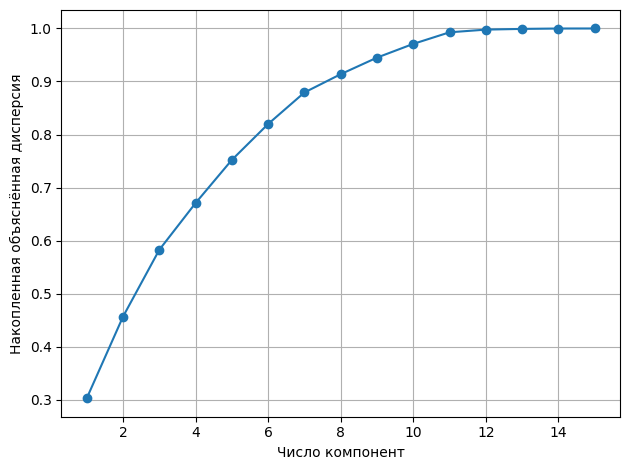

In [115]:
pca_full = PCA()
pca_full.fit(X_scaled)

explained = pca_full.explained_variance_ratio_

plt.figure()
plt.plot(range(1, len(explained) + 1), np.cumsum(explained), marker="o")
plt.xlabel("Число компонент")
plt.ylabel("Накопленная объяснённая дисперсия")
plt.grid()
plt.tight_layout()
plt.show()

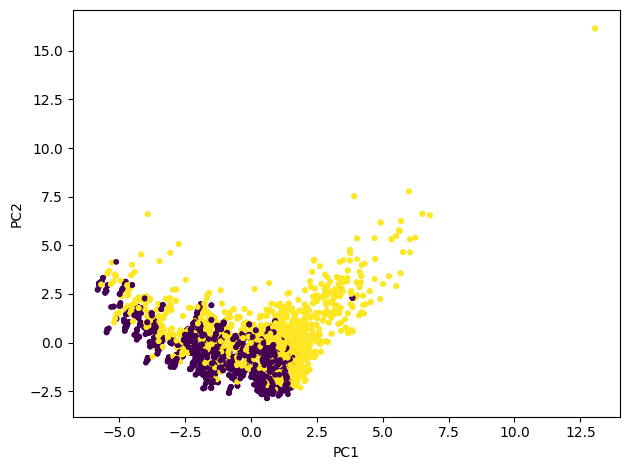

In [116]:
ever_fire = full_df.loc[num_df.index, "ever_fire"]

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=ever_fire)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [117]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=5)
pca.fit(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T,
    index=num_df.columns,
    columns=[f"PC{i+1}" for i in range(5)]
)

print(loadings)


                      PC1       PC2       PC3       PC4       PC5
pile_id         -0.065910 -0.226558 -0.203885  0.622811 -0.025441
temp_max_mean    0.310247  0.384081  0.242835  0.244734 -0.125584
temp_max_min     0.271006  0.317600  0.180409  0.290375 -0.173490
temp_max_max     0.285458  0.365940  0.249872  0.167021 -0.068833
n_measurements   0.164547  0.047013  0.091297 -0.181668  0.257674
temp_air_mean    0.416163 -0.164054 -0.150121  0.024731  0.254462
temp_air_min     0.412871 -0.172268 -0.129946  0.029172  0.253165
temp_air_max     0.415136 -0.152840 -0.169372  0.021960  0.249199
humidity_mean   -0.158805 -0.188132  0.497179  0.064019  0.147973
precip_sum      -0.139980  0.117485  0.145744  0.190360  0.684762
wind_avg_mean   -0.156355  0.431524 -0.428608 -0.011052  0.108063
wind_max_max    -0.183693  0.443871 -0.365183  0.037742  0.236173
cloudcover_mean -0.279476  0.074644  0.340831  0.135218  0.316775
fire_in_horizon  0.042952 -0.040657  0.027972 -0.105504  0.169858
ever_fire 

В качестве метрики для обучения будем использовать MAE, так как нам не особо важно предсказывать точное число, например нет разницы между 0.9 дней и 1.1 - главное, что это через 1 день. Нам не нужно так сильно штрафовать как в MSE, например

Для метрики качества итоговой будем использовать точность в пределах k дней

```
def accuracy_pm_k(y_true, y_pred, k=2):
    return (np.abs(y_true - y_pred) <= k).mean()
```



Параметры будем подбирать по сетке

In [101]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor


def accuracy_pm_k(y_true, y_pred, k=2):
    return (np.abs(y_true - y_pred) <= k).mean()


def train_xgb_with_cv(full_df: pd.DataFrame,
                      max_horizon_days: int = 30):

    df = full_df.copy()

    mask = (
        df["days_to_fire"].notna() &
        (df["days_to_fire"] >= 0) &
        (df["days_to_fire"] <= max_horizon_days)
    )
    df = df[mask].reset_index(drop=True)

    print(df.shape)

    target_col = "days_to_fire"
    y = df[target_col]

    possible_cat_cols = ["coal_grade", "stockyard", "location", "shift"]
    cat_cols = [c for c in possible_cat_cols if c in df.columns]

    for c in cat_cols:
        df[c] = df[c].astype("string")

    # выбираем признаки
    leak_cols = ["days_to_fire", "fire_start", "fire_in_horizon", "ever_fire"]
    drop_num = leak_cols + ["pile_id"]

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in drop_num]

    feature_cols = num_cols + cat_cols
    X = df[feature_cols]

    print("Числовые:", num_cols)
    print("Категориальные:", cat_cols)

    # разделим выборку на тест/траин
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42
    )

    # используем StandardScaler чтобы отнормировать числовые,
    # категориальные будем кодироваать через ван-хот
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ]
    )

    xgb_model = XGBRegressor(
        objective="reg:squarederror",
        eval_metric="mae",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

    pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", xgb_model)
    ])

    # перебираем по сетке гиперпараметры
    param_grid = {
        "model__n_estimators": [300, 500],
        "model__max_depth": [4, 6, 8],
        "model__learning_rate": [0.05, 0.1],
        "model__subsample": [0.7, 1.0],
        "model__colsample_bytree": [0.7, 1.0],
        "model__reg_lambda": [1, 3, 5],
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_absolute_error",
        verbose=2,
        n_jobs=-1
    )
    print(y_train)
    grid.fit(X_train, y_train)


    print('лучшие параметры:')
    print(grid.best_params_)
    print("score (mae):", -grid.best_score_)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    acc_pm2 = accuracy_pm_k(y_test.values, y_pred, k=2)

    print('Результат модели:')
    print(f"Ошибка MAE: {mae:.3f} дней")
    print(f"Точность +-2 дня: {acc_pm2:.3%}")

    return best_model, feature_cols


def predict_fire_date_for_row(model, row: pd.Series, feature_cols):
    x = row[feature_cols].to_frame().T
    pred_days = model.predict(x)[0]
    pred_days_round = int(np.round(pred_days))
    fire_date_pred = row["date"] + pd.Timedelta(days=pred_days_round)
    return pred_days, pred_days_round, fire_date_pred


if __name__ == "__main__":
    data_dir = "./data"

    full_df = build_full_dataset(data_dir, horizon_days=3)

    print('Обучение xgboost')
    best_model, feature_cols = train_xgb_with_cv(full_df, max_horizon_days=30)


Обучение xgboost
(399, 27)
Числовые: ['temp_max_mean', 'temp_max_min', 'temp_max_max', 'temp_max_std', 'n_measurements', 'to_stock_tons_daily', 'from_stock_tons_daily', 'net_flow', 'stock_tons', 'temp_air_mean', 'temp_air_min', 'temp_air_max', 'humidity_mean', 'precip_sum', 'wind_avg_mean', 'wind_max_max', 'cloudcover_mean', 'visibility_mean']
Категориальные: ['coal_grade', 'stockyard']
157     0.0
109    24.0
17     26.0
253    10.0
24     24.0
       ... 
71      8.0
106    26.0
270     2.0
348    26.0
102    28.0
Name: days_to_fire, Length: 279, dtype: float64
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


лучшие параметры:
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 500, 'model__reg_lambda': 5, 'model__subsample': 1.0}
score (mae): 2.5841999475025146
Результат модели:
Ошибка MAE: 0.973 дней
Точность +-2 дня: 83.333%


Посмотрим, как предсказывает наша модель

In [118]:
expl_row = full_df.iloc[0]
pred_days, pred_days_round, fire_date_pred = predict_fire_date_for_row(
        best_model, expl_row, feature_cols)

print("Предсказано дней до пожара:", pred_days)
print("Округлённо:", pred_days_round)
print("Предсказанная дата пожара:", fire_date_pred)

Предсказано дней до пожара: 22.264355
Округлённо: 22
Предсказанная дата пожара: 2020-06-20 00:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')